# 3D CNN for Lung Cancer Detection

First import the libraries:

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import os
from random import shuffle
import matplotlib.pyplot as plt

## Splitting training and validation set
### One-hot encoding
Performing one-hot encoding for labels (1D array):

In [2]:
def one_hot_encode(labels):
    one_hot = np.zeros((len(labels), 2))
    one_hot[np.arange(len(labels)), labels] = 1
    
    return one_hot

sample_labels = [1, 0, 1]
one_hot_sample_labels = one_hot_encode(sample_labels)
print(one_hot_sample_labels)

[[ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]]


### Saving Data

In [3]:
preprocessed_data_folder = './sample_images_preprocessed/'
train_valid_data_folder = './data/'

train_size = 0.8 # relative size of train set
batch_size = 5 # divide set into batches to prevent machine from running out of memory

In [4]:
patients = os.listdir(preprocessed_data_folder)
shuffle(patients) # randomize the order of data

# initialization
train_features_batch = []; train_labels_batch = []
valid_features_batch = []; valid_labels_batch = []


n_train = 0; n_train_batch = 0; n_valid = 0; n_valid_batch = 0

train_batch_id = 0
valid_batch_id = 0
for i in range(len(patients)):  
    if patients[i].startswith('.'): continue # ignore hidden files
    patient_data = np.load(preprocessed_data_folder + patients[i])
    if patient_data['set'] == 'test': continue # ignore test data
    
    if i < int(len(patients) * train_size): # train set
        train_features_batch.append(patient_data['data'])
        train_labels_batch.append(patient_data['label'])
        n_train += 1
        n_train_batch += 1
        
        #  if current train batch is full
        if (n_train_batch == batch_size): 
            # save the current batch
            np.savez_compressed(train_valid_data_folder + 'train_batch_' + str(train_batch_id),
                               features = np.array(train_features_batch),
                               labels = one_hot_encode(train_labels_batch))
            # initialization
            train_features_batch = []; train_labels_batch = []
            train_batch_id += 1
            n_train_batch = 0
            
    else: # validation set
        valid_features_batch.append(patient_data['data'])
        valid_labels_batch.append(patient_data['label'])
        n_valid += 1
        n_valid_batch += 1
        
        #  if current validation batch is full
        if (n_valid_batch == batch_size): 
            # save the current batch
            np.savez_compressed(train_valid_data_folder + 'valid_batch_' + str(valid_batch_id),
                               features = np.array(valid_features_batch),
                               labels = one_hot_encode(valid_labels_batch))
            # initialization
            valid_features_batch = []; valid_labels_batch = []
            valid_batch_id += 1
            n_valid_batch = 0

# save the remaining training and validation data set
if n_train_batch != 0:
    np.savez_compressed(train_valid_data_folder + 'train_batch_' + str(train_batch_id),
                        features = np.array(train_features_batch),
                        labels = one_hot_encode(train_labels_batch)) 
else:
    train_batch_id -= 1

if n_valid_batch != 0:
    np.savez_compressed(train_valid_data_folder + 'valid_batch_' + str(valid_batch_id),
                        features = np.array(valid_features_batch),
                        labels = one_hot_encode(valid_labels_batch)) 
else:
    valid_batch_id -= 1

print('Total data size: {:d}, Training data size: {:d}, Validation data size: {:d} '.format(
    n_train + n_valid, n_train, n_valid))
print('Number of train batches: {:d}, Number of validation batches: {:d}'.format(
    train_batch_id+1, valid_batch_id+1))

Total data size: 20, Training data size: 15, Validation data size: 5 
Number of train batches: 3, Number of validation batches: 1


### Loading Data

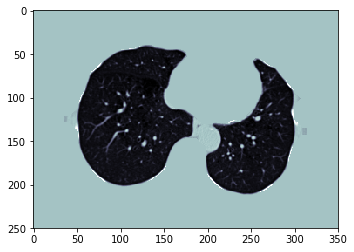

[[ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


In [4]:
def read_train_batch(batch_id):
    data = np.load(train_valid_data_folder + 'train_batch_' + str(batch_id) + '.npz')
    features = data['features']
    labels = data['labels']
    
    # add an additional dimension corresponds to the channel dimension in tensorflow
    new_shape = tuple(features.shape) + (1,)
    return features.reshape(new_shape), labels

def read_valid_batch(batch_id):
    data = np.load(train_valid_data_folder + 'valid_batch_' + str(batch_id) + '.npz')
    features = data['features']
    labels = data['labels']
    
    new_shape = tuple(features.shape) + (1,)
    return features.reshape(new_shape), labels

train_features_batch_sample, train_labels_batch_sample = read_train_batch(0)

plt.imshow(train_features_batch_sample[0,:,:,100,0], cmap=plt.cm.bone)
plt.show()
print(train_labels_batch_sample)

## Building Neural Network
Here we use Tensorflow to build a 3D Convolutional Neural Network. First, we define the layers in the neural net.

### Convolutional Layer

In [5]:
def conv3d(tensor, n_outputs, ksize, stride):
    # tensor: input tensor to the layer
    # n_outputs: number of outputs for convolutional layer
    # ksize: kernel size for convolutional layer
    # stride: stride size for convolutional layer
    
    # weight and bias tensor for convolutional layer
    weight = tf.Variable(tf.truncated_normal([ksize,
                                              ksize,
                                              ksize,
                                              tensor.get_shape().as_list()[4],
                                              n_outputs],
                                              stddev=0.1))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # convolutional layer
    tensor = tf.nn.conv3d(tensor,
                          weight,
                          strides = [1,stride,stride,stride,1],
                          padding = 'SAME')
    tensor = tf.nn.bias_add(tensor, bias)
    
    # activation layer
    tensor = tf.nn.relu(tensor)
    
    return tensor

### Max-pooling Layer

In [6]:
def maxpool(tensor, ksize, stride):
    # tensor: input tensor to the layer
    # ksize: kernel size for max-pooling layer
    # stride: stride size for max-pooling layer
    
    # max-pooling layer
    tensor = tf.nn.max_pool3d(tensor,
                              ksize = [1,ksize,ksize,ksize,1],
                              strides = [1,stride,stride,stride,1],
                              padding = 'SAME')
    
    return tensor

### Flatten Layer
A flatten layer is used to reshape a 5D tensor to a 2D tensor. The flattened layer would be the input of a fully-connected layer. 

In [7]:
def flatten(tensor):
    flattened_size = np.prod(tensor.get_shape().as_list()[1:])
    return tf.reshape(tensor, [-1, flattened_size])

### Fully-connected Layer

In [9]:
def fully_conn(tensor, n_outputs):
    # tensor: input 2D tensor to the layer
    # n_outputs: number of outputs of the fully-connected layer
    
    size = tensor.get_shape().as_list()[1]
    
    # weigth and bias tensor for the fully-connected layer
    weight = tf.Variable(tf.truncated_normal([size, n_outputs], stddev=0.1))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # fully-connected layer
    tensor = tf.matmul(tensor, weight)
    tensor = tf.nn.bias_add(tensor, bias)
    
    # activation layer
    tensor = tf.nn.relu(tensor)
    
    return tensor

### Output Layer

In [10]:
def output(tensor, n_outputs):
    # tensor: input 2D tensor to the layer
    # n_outputs: number of outputs of the output layer
    
    size = tensor.get_shape().as_list()[1]
    
    # weigth and bias tensor for the output layer
    weight = tf.Variable(tf.truncated_normal([size, n_outputs], stddev=0.1))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # output layer
    tensor = tf.matmul(tensor, weight)
    tensor = tf.nn.bias_add(tensor, bias)
    
    return tensor

### Convolutional Neural Network Model

In [16]:
def conv_net(x, keep_prob):
    # x: placeholder tensor that holds the input
    # keep_prob: placeholder tensor for the dropout layer
    
    # convolutional and max-pooling layers
    x = maxpool(x, 2, 2) # applying a max-pooling layer first to reduce the memory usage
    
    conv1 = conv3d(x, 32, 5, 2)
    conv1 = maxpool(conv1, 2, 2)
    
    conv2 = conv3d(conv1, 64, 5, 2)
    conv2 = maxpool(conv2, 2, 2)
    
    # flatten layer
    flat = flatten(conv2)
    
    # fully-connected layers
    fc1 = fully_conn(flat, 1024)
    fc2 = fully_conn(fc1, 128)
    
    # dropout layer
    dropout = tf.nn.dropout(fc2, keep_prob)
    
    # output layer
    y = output(dropout, 2)
    
    return y

### Building Network

In [17]:
data_shape = [250, 350, 350]
tf.reset_default_graph()

# inputs
x = tf.placeholder(tf.float32, (None, data_shape[0], data_shape[1], data_shape[2], 1), name='x')
y = tf.placeholder(tf.float32, (None, 2), name='y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# convolutional neural network model
logits = conv_net(x, keep_prob)

# cost function and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost) # Adam gradient descent optimizer

# accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

### Training Network

In [18]:
def train_conv_net(session, optimizer, keep_probability, features_batch, labels_batch):
    session.run(optimizer, feed_dict={
        x: features_batch,
        y: labels_batch,
        keep_prob: keep_probability
    })

# print out current training stats
def show_stats(session, features_batch, labels_batch, cost, accuracy):
    # training loss
    loss = session.run(cost, feed_dict={
        x: features_batch,
        y: labels_batch,
        keep_prob: 1.
    })
    
    # validation loss
    valid_loss = session.run(cost, feed_dict={
        x: valid_features_batch,
        y: valid_labels_batch,
        keep_prob: 1.
    })
    
    # validation accuracy
    valid_accuracy = session.run(accuracy, feed_dict={
        x: valid_features_batch,
        y: valid_labels_batch,
        keep_prob: 1.
    })
    
    print('Training Loss: {:>10.4f} Validation Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
        loss, valid_loss, valid_accuracy))

In [19]:
# hyperparameters
epochs = 2
batch_size = 5
n_batch = 3 # number of training batches
keep_probability = 0.7

In [ ]:
valid_features_batch, valid_labels_batch = read_valid_batch(0)

# start training
with tf.Session() as sess:
    # initialization
    sess.run(tf.global_variables_initializer())
    
    # training
    for epoch in range(epochs):
        # loop over training batches
        for batch_index in range(n_batch):
            features_batch, labels_batch = read_train_batch(batch_index)
            #features_batch = features_batch[:1]
            #labels_batch = labels_batch[:1]
            train_conv_net(sess, optimizer, keep_probability, features_batch, labels_batch)
            print('Epoch {:>2}, Batch {:>2}:  '.format(epoch + 1, batch_index))
            show_stats(sess, features_batch, labels_batch, cost, accuracy)